# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
from unityagents import UnityEnvironment
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from constants import *

from ddpg_agent import Agent


Loading new constants


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
if (SINGLE_AGENT):
    # select this option to load version 1 (with a single agent) of the environment
    env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')
else:
    # select this option to load version 2 (with 20 agents) of the environment
    env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


In [5]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=0)

/home/workspace/ddpg_network.py:81: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(param)
/home/workspace/ddpg_network.py:79: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(param, 0.0)
/home/workspace/ddpg_network.py:168: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(param)
/home/workspace/ddpg_network.py:166: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(param, 0.0)


In [6]:
def ddpg():
    scores_window = deque(maxlen=100)
    agent_scores = []
    scores_moving_avg = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        states = env_info.vector_observations       
        agent.reset()
        scores = np.zeros(num_agents) 
        for t in range(max_t):
            actions = agent.act(states, add_noise=True)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations   # get the next state
            rewards = env_info.rewards                   # get the reward
            dones = env_info.local_done 
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, i_episode, done)    
            states = next_states
            scores += rewards
            if np.any(dones):
                break 
            
        agent_scores.append(np.mean(scores)) 
        scores_window.append(agent_scores[-1]) 
        scores_moving_avg.append(np.mean(scores_window))
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, scores_moving_avg[-1], agent_scores[-1]), end="")
        if i_episode % 100 == 0:
            print('\nEpisode {}\tAverage Score: {:.2f}'.format(i_episode, scores_moving_avg[-1]))
        if scores_moving_avg[-1] >= TARGET_SCORE:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, scores_moving_avg[-1]))
            break
    return agent_scores, scores_moving_avg


In [7]:
scores, scores_mean = ddpg()

Episode 100	Average Score: 19.09	Score: 35.86
Episode 100	Average Score: 19.09
Episode 136	Average Score: 30.15	Score: 38.21
Environment solved in 36 episodes!	Average Score: 30.15


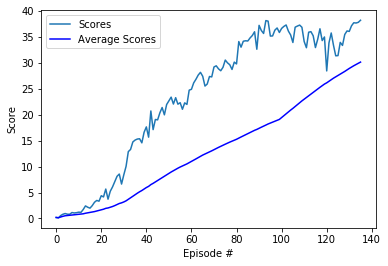

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='Scores')
plt.plot(np.arange(len(scores)), scores_mean, c='b', label='Average Scores')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()

In [9]:
for episode in range(2):
    env_info = env.reset(train_mode=False)[brain_name]        
    states = env_info.vector_observations       
    score = np.zeros(num_agents)               
    while True:
        actions = agent.act(states, add_noise=False)                       
        env_info = env.step(actions)[brain_name]        
        next_states = env_info.vector_observations     
        rewards = env_info.rewards       
        dones = env_info.local_done
        score += rewards
        states = next_states
        if np.any(dones):                              
            break
    print('Episode: \t{} \tScore: \t{:.2f}'.format(episode, np.mean(score)))      

env.close()

Episode: 	0 	Score: 	39.01
Episode: 	1 	Score: 	38.92
